## Chapter 08. 梯度下降
从事数据科学工作时，常常会面临这样的需要：为某种特定的情形寻找最佳模型。“最佳” 常常会被解读为某种类似于“最小化模型残差”或者“最大化数据的可能性”。换句话说，它代表了优化某种问题的解决方案。

这意味着我们需要解决一连串的最优化问题。尤其是，我们需要从零开始解决问题。我们采用的方法是一种叫作梯度下降（gradient descent）的技术， 适合从零开始逐步解决问题。

首先导入本章需要的包：

In [1]:
import matplotlib.pyplot as plt
import math, random

# 两个向量相减
def vector_subtract(v, w):
    return [v_i - w_i for v_i, w_i in zip(v,w)]

# 向量的平方
def sum_of_squares(v):
    return dot(v, v)

# 向量距离的平方
def squared_distance(v, w):
    return sum_of_squares(vector_subtract(v, w))

# 两个向量的距离 
def distance(v, w):
   return math.sqrt(squared_distance(v, w))

### 8.1 梯度下降的思想
假设我们拥有某个函数f，这个函数输入一个实数向量，输出一个实数。一个简单的例子如下：

In [2]:
# 向量的平方和
def sum_of_squares(v):
    """computes the sum of squared elements in v"""
    return sum(v_i ** 2 for v_i in v)

我们常常需要最大化（或最小化）这个函数。这意味着我们需要找出能计算出最大（或最小）可能值的输入v。

对我们的函数来说，梯度（在微积分里，这表示偏导数向量）给出了输入值的方向，在这个方向上，函数增长得最快：
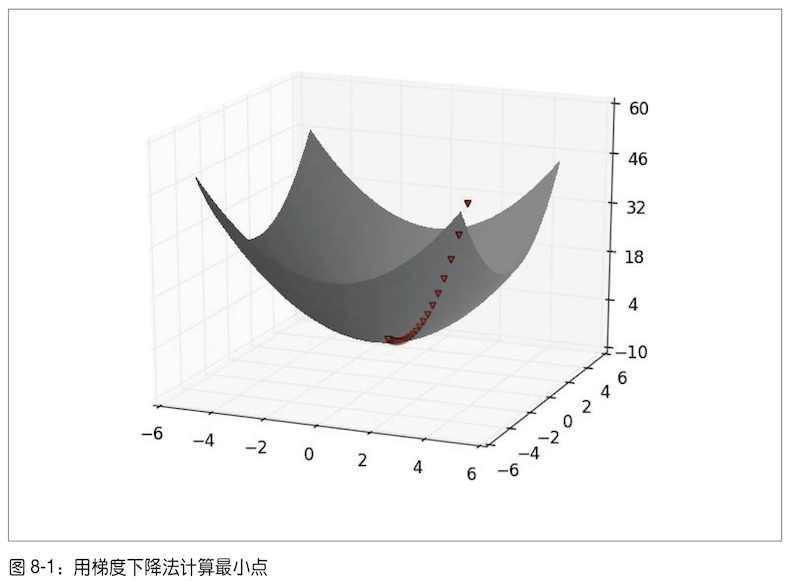

如果一个函数有一个全局最小点，那么这个方法很可能会找到它。如果这个函数有多个（局部）最小点，那么这种方法可能找不到这个点，但你可以通过多尝试一些初始点来重复运行这个方法。如果一个函数没有最小点，也许 计算会陷入死循环。

### 8.2 估算梯度
如果f是单变量函数，那么它在x点的导数衡量了当x发生变化时，f(x)变化了多少。导数通过差商的极限来定义：
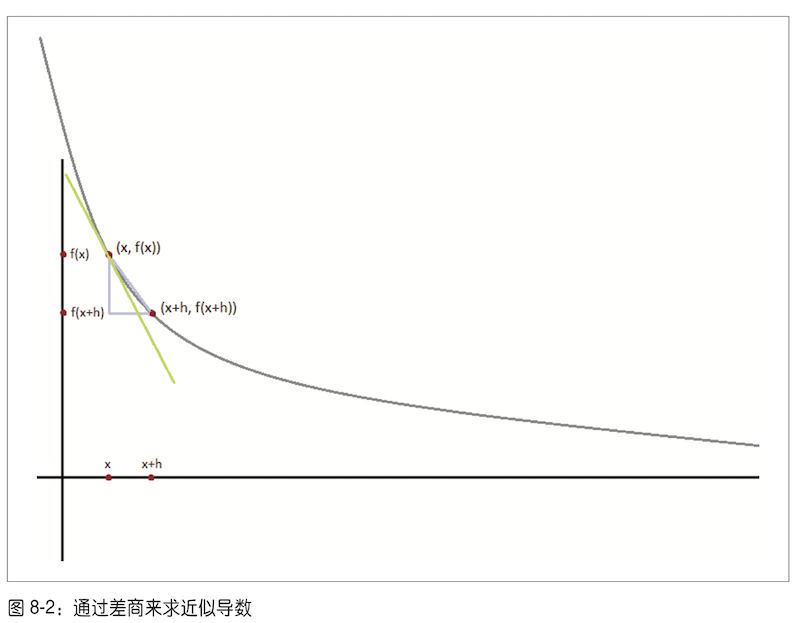

In [3]:
# 导数通过差商的极限来定义
def difference_quotient(f, x, h):
    # print("f(x+h) = ", f(x + h))
    # print("f(x)   = ", f(x))
    # print("(f(x+h)-f(x))/h = ", (f(x + h) - f(x)) / h)
    return (f(x + h) - f(x)) / h

很多函数可以精确地计算导数，但是如果算不出梯度（或不想算）呢？ Python中无法直接运算极限，但可以通过计算一个很小的变动e的差商来估算微分：

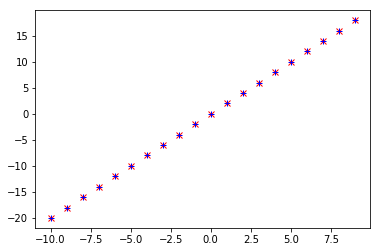

In [4]:
# 梯度估算 
def plot_estimated_derivative():
    # 平方函数
    def square(x):
        return x * x
    # 平方函数的导函数
    def derivative(x):
        return 2 * x 

    # 导数变化 
    derivative_estimate = lambda x: difference_quotient(square, x, h=0.000001)

    x = range(-10,10)
    plt.plot(x, list(map(derivative, x)), 'rx', label='Actual')
    plt.plot(x, list(map(derivative_estimate, x)), 'b+', label='Estimate') 
    plt.show() # purple *, hopefully

plot_estimated_derivative()

当f是一个多变量函数时，它有多个偏导数，每个偏导数表示仅有一个输入变量发生微小变化时函数f的变化。我们把导数看成是其第i个变量的函数，其他变量保持不变，以此来计算它第i个偏导数：

In [5]:
# 差商法计算偏导数
def partial_difference_quotient(f, v, i, h):
    # add h to just the i-th element of v
    w = [v_j + (h if j == i else 0)
         for j, v_j in enumerate(v)]
    return (f(w) - f(v)) / h

def estimate_gradient(f, v, h=0.00001):
    return [partial_difference_quotient(f, v, i, h) for i, _ in enumerate(v)]

### 8.3 使用梯度
很容易看出，当输入v是零向量时，函数sum_of_squares取值最小。但如果不知道输入是什么，可以用梯度方法从所有的三维向量中找到最小值。我们先找出随机初始点，并在梯度的反方向以小步逐步前进，直到梯度变得非常非常小：

In [6]:
def step(v, direction, step_size):
    """move step_size in the direction from v"""
    # print("v :", v)
    # print("d :", direction)
    # print("z :", list(zip(v, direction)))
    return [v_i + step_size * direction_i for v_i, direction_i in zip(v, direction)]

def sum_of_squares_gradient(v):
    return [2 * v_i for v_i in v]

# 选取一个随机初始值 
v = [random.randint(-10,10) for i in range(3)]

tolerance = 0.0000001

while True:
    gradient = sum_of_squares_gradient(v) # 计算v的梯度
    next_v = step(v, gradient, -0.01)     # 取负的梯度步长
    if distance(next_v, v) < tolerance:   # 如果收敛了就停止
        break
    v = next_v                            # 如果没汇合就继续

v

[-1.8151376396131018e-06, 3.2672477513035825e-06, 3.2672477513035825e-06]

### 8.4 选择正确步长
尽管向梯度的反向移动的逻辑已经清楚了，但移动多少还不明了。事实上，选择合适的步长更像艺术而非科学。主流的选择方法有：
- 使用固定步长 
- 随时间增长逐步减小步长
- 在每一步中通过最小化目标函数的值来选择合适的步长

最后一种方法看上去不错，但它的计算代价也最大。我们可以尝试一系列步长，并选出使 目标函数值最小的那个步长来求其近似值：
```python
step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
```

某些步长可能会导致函数的输入无效。所以，我们需要创建一个对无效输入值返回无限值（即这个值永远不会成为任何函数的最小值）的“安全应用”函数：

In [8]:
def safe(f):
    """define a new function that wraps f and return it"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf') # this means "infinity" in Python
    return safe_f

### 8.5 综合
一个MBGD算法的实现：

In [9]:
# 我们称它为 minimize_batch,因为在每一步梯度计算中,它都会搜索整个数据集
# (因为target_fn 代表整个数据集的残差)
def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

    theta = theta_0                           # set theta to initial value
    target_fn = safe(target_fn)               # safe version of target_fn
    value = target_fn(theta)                  # value we're minimizing

    while True:
        gradient = gradient_fn(theta)
        next_thetas = [step(theta, gradient, -step_size) for step_size in step_sizes]
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)
        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value

# 有时候,我们需要最大化某个函数,这只需要最小化这个函数的负值(相应的梯度函数也 需取负)
def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)

def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]

def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                          negate_all(gradient_fn),
                          theta_0,
                          tolerance)

# test
v = [random.randint(-10,10) for i in range(3)]
v = minimize_batch(sum_of_squares, sum_of_squares_gradient, v)
v

[0.001063382396627933, -0.0008507059173023465, 0.0007443676776395526]

### 8.6 随机梯度下降法
正如之前提到的，我们常常用梯度下降的方法，通过最小化某种形式的残差来选择模型参数。如果使用之前的批处理方法，每个梯度计算步都需要我们预测并计算整个数据集的梯度，这使每一步都会耗费很长时间。

现在，这些残差函数常常具有可加性（additive），意味着整个数据集上的预测残差恰好是每个数据点的预测残差之和。

在这种情形下，我们转而使用一种称为随机梯度下降（stochastic gradient descent）的技术，它每次仅计算一个点的梯度（并向前跨一步）。这个计算会反复循环，直到达到一个停止点。

在每个循环中，我们都会在整个数据集上按照一个随机序列迭代：

In [1]:
def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)]  # create a list of indexes
    random.shuffle(indexes)                    # shuffle them
    for i in indexes:                          # return the data in that order
        yield data[i]

def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    data = list(zip(x, y))
    theta = theta_0                             # initial guess
    alpha = alpha_0                             # initial step size
    min_theta, min_value = None, float("inf")   # the minimum so far
    iterations_with_no_improvement = 0

    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data )

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))

    return min_theta

def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimize_stochastic(negate(target_fn),
                               negate_all(gradient_fn),
                               x, y, theta_0, alpha_0)